# Model Predictive Control Example

In this example, we will see an MPC example for controlling the data center model. We skip the modelling part and assume to have a linear model given.

At first we make some imports and specify the system matrices for the dynamical system representing the temperatures
$$x_{k+1}=Ax_k+Bu_k$$
$$y_k = Cx_k$$
and the linear regression to approximate the power demand $p_k$
$$p_k = a [y_k^T u_k^T]^T+ b$$
where $x_k$ is the internal state, $y_k$ the measured temperature, $u_k$ the control input. The control input consists of the two temperature setpoints and the external temperature.

In [1]:
import numpy as np
import energym

In [2]:
A = np.array([[ 0.59047923,  0.43091412,  0.,          0.        ],
              [ 0.12177907, -0.48111516,  0.,          0.        ],
              [ 0.,          0.,          0.57671655,  0.42621476],
              [ 0.,          0.,          0.12818792, -0.46633794]])
B = np.array([[-0.00593225, -0.00081038, -0.01050894],
              [ 0.00327361, -0.00107018,  0.03460421],
              [-0.00121847, -0.00574196, -0.01076388],
              [ 0.00062535,  0.00171538,  0.03565957]])
C = np.array([[-61.83732662,  -3.01037251,   0.,           0.        ],
              [  0.,           0.,         -61.98746739,  -2.64941817]])
a = np.array([ 2.72949188,  3.21844095,  0.50712081,  0.20089851, -0.4114797 ])
b = -64.8936962950796

Next, we define a class to handle the MPC problems. The cost function to be minimized consists of one term to minimize the temperature deviation to a temperature interval defined by a setpoint $ybar$ and a tolerance $eps$, and one term to minimize the power demand. The two objectives are balanced using the weighting parameter $w$.

In [3]:
import casadi as ca


class MPC():
    def __init__(self, A, B, C, l_y, u_y, l_u, u_u, a=None, b=None):
        self.A = A
        self.B = B
        self.C = C
        self.l_y = l_y
        self.u_y = u_y
        self.l_u = l_u
        self.u_u = u_u
        self.a = a
        self.b = b

    def solve(self, x0, p0, ybar, N, Q, T, w=1):
        """Solves the optimization problem for the current input.
        
        Parameters
        -----------
        x0 : np.array
            Current state
        p0 : float
            Current power demand
        ybar : np.array
            Temperature setpoints for the two zones
        N : int
            MPC horizon length
        Q : np.array
            Cost matrix for temperature deviation
        T : np.array
            External temperature forecast
        w : float
            Weighting factor of the objectives
        """
        opti = ca.Opti()
        x = opti.variable(len(self.A[0]), N)
        u = opti.variable(3, N-1)
        eps = 0
        eps_vec = np.array([eps, eps])

        cost = 0
        
        opti.subject_to(x[:, 0] == x0)
        
        pw = opti.variable(1, N)
        inp = opti.variable(5, N)
        opti.subject_to(pw[:, 0] == p0)
        for i in range(N):
            arg = ca.fmax(
                ca.fabs(ca.mtimes(self.C, x[:, i]) - ybar) - eps_vec, np.zeros((2, 1)))
            cost = cost + w * ca.bilin(Q, arg, arg)
            #opti.subject_to(opti.bounded(
            #    self.l_y, ca.mtimes(self.C, x[:, i])[0], self.u_y))
            #opti.subject_to(opti.bounded(
             #   self.l_y, ca.mtimes(self.C, x[:, i])[1], self.u_y))
        for i in range(N-1):
            cost = cost + (1 - w) * pw[:, i]
            opti.subject_to(inp[:2, i] == ca.mtimes(self.C, x[:, i]))
            opti.subject_to(inp[2:, i] == u[:, i])
            opti.subject_to(pw[:, i+1] == ca.dot(self.a, inp[:, i]) + self.b)
            opti.subject_to(x[:, i+1] == ca.mtimes(self.A,
                                                   x[:, i]) + ca.mtimes(self.B, u[:, i]))
            opti.subject_to(opti.bounded(self.l_u, u[0, i], self.u_u))
            opti.subject_to(opti.bounded(self.l_u, u[1, i], self.u_u))
            opti.subject_to(u[2, i] == T[i])
            opti.set_initial(u[0, i], ybar[0])
            opti.set_initial(u[1, i], ybar[1])

        opti.minimize(cost)
        opti.solver('ipopt')
        sol = opti.solve()
        if N-1 == 1:
            ures = sol.value(u).T
        else:
            ures = sol.value(u).T[0]
        return ures 


To track the internal states, we define a simple Luenberger observer.

In [4]:
import control

class StateObserver():
    def __init__(self, A, B, C, y0):
        self.A = A
        self.B = B
        self.C = C
        self.u_len = self.B.shape[1]
        self.y_len = self.C.shape[0]
        evs = [0.8 + 0.05 * i for i in range(A.shape[0])]
        self.L = control.place(A.T, C.T, evs).T
        self.state = np.dot(np.linalg.pinv(self.C), y0).reshape((-1,1))

    def updateState(self, y, u):
        y = y.reshape((self.y_len,1))
        u = u.reshape((self.u_len,1))
        yhat = np.dot(self.C, self.state)
        self.state = np.dot(self.A, self.state) + np.dot(self.L, y-yhat) + np.dot(self.B, u)
    
    def getState(self):
        return self.state

To initialize the environment (i.e. run the simulation for one day with fixed inputs for converging state estimations) we provide the following function. Additionally, we define two functions to handle the inputs and outputs.

In [5]:
def initEnv(env, A, B, C, sp_temp):
    luen = StateObserver(A, B, C, np.array([sp_temp, sp_temp]))
    for _ in range(192):
        u = np.array([sp_temp, sp_temp])
        out = env.step(arrayToInput(u))
        y = outputToArray([out])
        u = np.array([sp_temp, sp_temp, out["Ext_T"]])
        luen.updateState(y, u)
    return luen, out

def arrayToInput(val):
    inputs = {'Z01_T_Thermostat_sp':[], 'Z02_T_Thermostat_sp':[]}
    
    inputs['Z01_T_Thermostat_sp'].append(val[0])
    inputs['Z02_T_Thermostat_sp'].append(val[1])
    return inputs

def outputToArray(outputs):
    """return the outputs Z01_T and Z02_T out of the list of collected outputs"""
    vals = [[],[]]
    for output in outputs:
        vals[0].append(output['Z01_T'])
        vals[1].append(output['Z02_T'])
    return np.array(vals)

These tools can now be used to formulate and perform the receding horizon control.

In [6]:
env = energym.make("DatacenterThermostat-v0", simulation_days=100)

#############################################################
# Hyperparameters
#############################################################

num_steps = 480  # simulation timesteps, 5 days
sp_temp = 21  # Goal temperature
inputs = env.get_inputs()  # list of input names
lower_tol = 0.2  # lower tolerance in RBC
upper_tol = 1.0  # upper tolerance in RBC
N_MPC = 10  # MPC horizopn length
outputCollection = {}  # dict to save all simulation data
kpiDict = {}  # dict to save the kpis from all simulations
T_lower = 15
T_upper = 26
u_lower = 18
u_upper = 23
u_lower_pw_only = 15
T_lower_pw_only = 19
Q = np.diag(np.array([1, 1]))
w = 0.85

mpc = MPC(A, B, C, T_lower, T_upper, u_lower, u_upper, a=a, b=b)
outputList =[]
luen, out = initEnv(env, A, B, C, sp_temp)

for _ in range(num_steps):
    x0 = luen.getState()
    forecast = env.get_forecast(N_MPC)
    u = mpc.solve(
        x0,
        out["Fa_Pw_All"],
        np.array([sp_temp, sp_temp]),
        N_MPC,
        Q,
        forecast["Dry Bulb Temperature Prediction"],
        w=w,
    )
    out = env.step(arrayToInput(u))
    outputList.append(out)
    obs = outputToArray([out])
    luen.updateState(obs, u)
    print(out["Z01_T"], out["Z02_T"])
    
env.print_kpis()

[OK] The current working directory is %s

[OK] fmiInstantiateSlave: Path to fmuUnzipLocation is not %s.

[OK] fmiInstantiateSlave: Path to fmuUnzipLocation is not %s.

[OK] fmiInstantiateSlave: Path to fmuUnzipLocation is not %s.

[OK] Command executes to copy content of resources folder: %s

[OK] fmiInstantiateSlave: Path to model description file is %s.

[OK] fmiInstantiateSlave: The FMU modelIdentifier is %s.

[OK] fmiInstantiateSlave: The FMU modelGUID is %s.

[OK] fmiInstantiateSlave: Slave %s is instantiated.

[OK] fmiInstantiateSlave: Instantiation of %s succeded.

[OK] fmiInitializeSlave: The sockfd is %d.

[OK] fmiInitializeSlave: The port number is %d.

[OK] fmiInitializeSlave: This hostname is %s.

[OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: %d.

[OK] fmiInitializeSlave: The number of input variables is %d.

[OK] fmiInitializeSlave: The number of output variables is %d.

[OK] Get input file from resource folder %s.

[OK] Searching for following pat

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

21.43428260369291 21.86576674454567
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.4970000e+003 9.09e+004 4.95e-001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

  10 1.2381804e+004 1.42e-014 3.77e-011  -8.6 7.43e-003  -8.3 1.00e+000 1.00e+000f  1
  11 1.2381804e+004 4.26e-014 8.13e-013  -8.6 4.80e-004  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  5.5951512750100028e+002   1.2381804482104239e+004
Dual infeasibility......:  8.1270233598385033e-013   1.7984717359198539e-011
Constraint violation....:  4.2632564145606011e-014   4.2632564145606011e-014
Complementarity.........:  4.2006082907251645e-009   9.2957469789897832e-008
Overall NLP error.......:  4.2006082907251645e-009   9.2957469789897832e-008


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluati


Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.4970000e+003 7.93e+004 4.95e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.2127564e+004 4.26e-014 7.93e+000  -1.0 7.93e+004  -4.0 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.03462122721132 23.03386248066174
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.00527156533031 23.00535027730045
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        10
       nlp_g  |   1.00ms (100.00us) 999.00us ( 99.90us)        10
  nlp_grad_f  |        0 (       0)        0 (       0)        11
  nlp_hess_l  |        0 (       0)        0 (       0)         9
   nlp_jac_g  |   2.00ms (181.82us)   2.03ms (184.91us)        11
       total  |  13.00ms ( 13.00ms)  12.99ms ( 12.99ms)         1
23.0006306002291 23.00064470863429
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
      

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.11205283909248 23.10533978491931
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

   8 1.1982373e+004 4.26e-014 2.73e-009  -5.7 5.98e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.1982373e+004 4.26e-014 2.84e-010  -5.7 1.86e-002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1982372e+004 2.84e-014 1.82e-011  -8.6 3.57e-003  -8.3 1.00e+000 1.00e+000f  1
  11 1.1982372e+004 2.84e-014 1.46e-013  -8.6 8.65e-005  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  5.4146538950500258e+002   1.1982372338387531e+004
Dual infeasibility......:  1.4641896601763837e-013   3.2401822946226274e-012
Constraint violation....:  2.8421709430404007e-014   2.8421709430404007e-014
Complementarity.........:  2.5728175657828847e-009   5.6935232850500701e-008
Overall NLP error.......:  2.5728175657828847e-009   5.6935232850500701e-008


Number of objective function evaluations             = 12
Number of objective gradient

23.20419723420213 23.20283257391205
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00304274051377 23.00306712596613
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

   3 1.4684457e+004 2.84e-014 2.81e-003  -2.5 1.49e+000  -5.0 7.63e-001 1.00e+000f  1
   4 1.4680348e+004 4.26e-014 9.65e-004  -2.5 1.19e+000  -5.4 9.21e-001 1.00e+000f  1
   5 1.4679177e+004 4.26e-014 2.50e-004  -3.8 6.55e-001  -5.9 9.50e-001 1.00e+000f  1
   6 1.4679041e+004 4.26e-014 1.11e-007  -3.8 2.69e-001  -6.4 1.00e+000 1.00e+000f  1
   7 1.4679001e+004 5.68e-014 2.02e-005  -5.7 1.43e-001  -6.9 9.81e-001 1.00e+000f  1
   8 1.4678999e+004 4.26e-014 2.56e-009  -5.7 5.59e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.4678998e+004 2.84e-014 2.07e-010  -5.7 1.36e-002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4678998e+004 2.84e-014 1.04e-011  -8.6 2.05e-003  -8.3 1.00e+000 1.00e+000f  1
  11 1.4678998e+004 4.26e-014 3.81e-014  -8.6 2.25e-005  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  6.63321835076683

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.00175339929804 23.00178175204383
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

   9 1.5143057e+004 5.68e-014 4.31e-010  -5.7 2.83e-002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5143057e+004 1.42e-014 1.31e-008  -8.6 9.09e-003  -8.3 1.00e+000 1.00e+000f  1
  11 1.5143057e+004 2.84e-014 1.50e-012  -8.6 8.84e-004  -8.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  6.8429197847220257e+002   1.5143057032179970e+004
Dual infeasibility......:  1.4977805254330666e-012   3.3145172867524358e-011
Constraint violation....:  2.8421709430404007e-014   2.8421709430404007e-014
Complementarity.........:  9.4460654255738156e-009   2.0903694909376808e-007
Overall NLP error.......:  9.4460654255738156e-009   2.0903694909376808e-007


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.00184816794894 23.00167086016695
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.21275179784478 23.20622770605726
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.20130942436673 23.19976084527453
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00075993065799 23.00077445697504
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.00095363432064 23.0009570845388
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

23.00236048378691 23.00234060950707
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00040737200734 23.00040938839815
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00982789531098 23.00953444110611
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.01867764356758 23.01879647903194
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.0069910991063 23.00711501670907
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        12
       nlp_g  |   1.00ms ( 83.33us)   1.03ms ( 85.67us)        12
  nlp_grad_f  |        0 (       0)        0 (       0)        13
  nlp_hess_l  |        0 (       0)        0 (       0)        11
   nlp_jac_g  |   1.00ms ( 76.92us) 970.00us ( 74.62us)        13
       total  |  19.00ms ( 19.00ms)  18.95ms ( 18.95ms)         1
23.00985452485839 23.00945063528881
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower a

23.02728641053593 23.02512497055784
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

   1 1.5186276e+004 2.84e-014 9.56e+000  -1.0 9.56e+004  -4.0 9.20e-001 1.00e+000h  1
   2 1.5158687e+004 4.26e-014 7.57e-005  -1.0 2.27e+000  -4.5 1.00e+000 1.00e+000f  1
   3 1.5148689e+004 1.42e-014 1.77e-003  -2.5 1.10e+000  -5.0 7.89e-001 1.00e+000f  1
   4 1.5144899e+004 2.84e-014 9.27e-006  -2.5 1.35e+000  -5.4 9.99e-001 1.00e+000f  1
   5 1.5143916e+004 4.26e-014 2.49e-004  -3.8 7.86e-001  -5.9 9.52e-001 1.00e+000f  1
   6 1.5143799e+004 2.84e-014 1.60e-007  -3.8 3.88e-001  -6.4 1.00e+000 1.00e+000f  1
   7 1.5143752e+004 2.84e-014 2.81e-005  -5.7 1.95e-001  -6.9 9.78e-001 1.00e+000f  1
   8 1.5143749e+004 4.26e-014 4.02e-009  -5.7 8.79e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.5143748e+004 4.26e-014 6.12e-010  -5.7 4.02e-002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5143748e+004 2.84e-014 1.97e-007  -8.6 1.76e-002  -8.3 9.98e-001 1.00e+000f  1
  11 1.5143748e+004 2.84e-014 7.45e-012  -8.6 4.40e-003  -8

   3 1.4621732e+004 4.26e-014 3.21e-003  -2.5 1.69e+000  -5.0 7.56e-001 1.00e+000f  1
   4 1.4619401e+004 4.26e-014 4.81e-004  -2.5 8.85e-001  -5.4 9.58e-001 1.00e+000f  1
   5 1.4618657e+004 2.84e-014 2.07e-004  -3.8 5.95e-001  -5.9 9.61e-001 1.00e+000f  1
   6 1.4618568e+004 2.84e-014 1.09e-007  -3.8 2.65e-001  -6.4 1.00e+000 1.00e+000f  1
   7 1.4618538e+004 4.26e-014 1.33e-005  -5.7 1.27e-001  -6.9 9.86e-001 1.00e+000f  1
   8 1.4618535e+004 2.84e-014 1.75e-009  -5.7 3.83e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.4618535e+004 2.84e-014 7.83e-011  -8.6 5.14e-003  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4618535e+004 2.84e-014 4.09e-013  -8.6 8.04e-005  -8.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  6.6058960982838505e+002   1.4618534852375311e+004
Dual infeasibility......:  4.0850959767690931e-013  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   6 7.9983403e+003 2.84e-014 1.19e-007  -3.8 2.90e-001  -6.4 1.00e+000 1.00e+000f  1
   7 7.9983100e+003 2.84e-014 2.08e-005  -5.7 1.47e-001  -6.9 9.81e-001 1.00e+000f  1
   8 7.9983073e+003 2.84e-014 2.69e-009  -5.7 5.89e-002  -7.3 1.00e+000 1.00e+000f  1
   9 7.9983067e+003 2.84e-014 2.48e-010  -5.7 1.63e-002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.9983064e+003 4.26e-014 1.36e-011  -8.6 2.67e-003  -8.3 1.00e+000 1.00e+000f  1
  11 7.9983064e+003 1.42e-014 6.85e-014  -8.6 4.04e-005  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  3.6143143932583632e+002   7.9983063825383806e+003
Dual infeasibility......:  6.8497074331985708e-014   1.5158077776427800e-012
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  2.5203490551560442e-009   5.577412958784122

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

Constraint violation....:  2.8421709430404007e-014   2.8421709430404007e-014
Complementarity.........:  3.6613100834212475e-009   8.1023056166068725e-008
Overall NLP error.......:  3.6613100834212475e-009   8.1023056166068725e-008


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 12
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        12
       nlp_g  |   1.00ms ( 83.33us) 984.00us ( 82.00us)        12


23.12827646959056 23.14148119382655
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.016
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        13
       nlp_g  |        0 (       0)        0 (       0)        13
  nlp_grad_f  |        0 (       0)        0 (       0)        14
  nlp_hess_l  |        0 (       0)        0 (       0)        12
   nlp_jac_g  |        0 (       0)        0 (       0)        14
       total  |  18.00ms ( 18.00ms)  17.92ms ( 17.92ms)         1
23.00031250504282 22.59485521561002
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more ef

   2 1.3090806e+004 2.84e-014 1.02e-004  -1.0 3.07e+000  -4.5 1.00e+000 1.00e+000f  1
   3 1.3088439e+004 4.26e-014 1.05e-003  -2.5 9.92e-001  -5.0 8.52e-001 1.00e+000f  1
   4 1.3086101e+004 2.84e-014 4.33e-006  -2.5 1.17e+000  -5.4 1.00e+000 1.00e+000f  1
   5 1.3085528e+004 4.26e-014 9.75e-005  -3.8 6.52e-001  -5.9 9.82e-001 1.00e+000f  1
   6 1.3085479e+004 4.26e-014 1.27e-007  -3.8 3.09e-001  -6.4 1.00e+000 1.00e+000f  1
   7 1.3085460e+004 5.68e-014 2.32e-005  -5.7 1.59e-001  -6.9 9.82e-001 9.98e-001f  1
   8 1.3085458e+004 4.26e-014 3.32e-009  -5.7 7.25e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.3085458e+004 7.11e-014 5.06e-010  -5.7 3.32e-002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3085458e+004 2.84e-014 2.44e-007  -8.6 1.45e-002  -8.3 9.98e-001 1.00e+000f  1
  11 1.3085458e+004 4.26e-014 5.45e-012  -8.6 3.22e-003  -8.8 1.00e+000 1.00e+000f  1
  12 1.3085458e+004 2.84e-014 1.01e-013  -8.6 1.79e-004  -9

23.00784108033844 22.73884408769488
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

22.93035215098801 22.72400731732406
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

22.95778148173569 22.71563940193151
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00155564222466 22.97757998775949
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00291708395717 22.96355769000978
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

  nlp_grad_f  |   1.00ms ( 71.43us) 997.00us ( 71.21us)        14
  nlp_hess_l  |   1.00ms ( 83.33us) 997.00us ( 83.08us)        12
   nlp_jac_g  |        0 (       0)        0 (       0)        14
       total  |  18.00ms ( 18.00ms)  17.95ms ( 17.95ms)         1
23.00822712714309 22.86342029839395
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints......

23.11098469540756 23.04831950825634
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00774389773183 22.77907677170308
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

22.83303164272919 22.46724574432416
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.4970000e+003 8.76e+004 4.95e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.3261885e+004 2.84e-014 8.76e+000  -1.0 8.76e+004  -4.0 9.81e-001 1.00e+000h  1
   2 1.3259695e+004 4.26e-014 8.84e-005  -1.0 2.65e+000  -4.5 1.00e+000 1.00e+000f  1
   3 1.3258995e+004 2.84e-014 3.50e-004  -2.5 5.94e-001  -5.0 8.93e-001 1.00e+000f  1
   4 1.3257953e+004 4.26e-014 4.37e-006  -2.5 1.18e+000  -5.4 

   2 1.0896709e+004 4.26e-014 9.40e-005  -1.0 2.82e+000  -4.5 1.00e+000 1.00e+000f  1
   3 1.0895999e+004 4.26e-014 6.63e-004  -2.5 8.87e-001  -5.0 9.01e-001 1.00e+000f  1
   4 1.0895145e+004 4.26e-014 1.17e-003  -3.8 1.23e+000  -5.4 8.63e-001 1.00e+000f  1
   5 1.0894936e+004 4.26e-014 6.95e-007  -3.8 5.63e-001  -5.9 1.00e+000 1.00e+000f  1
   6 1.0894881e+004 2.84e-014 1.21e-007  -3.8 2.94e-001  -6.4 1.00e+000 1.00e+000f  1
   7 1.0894864e+004 2.84e-014 5.72e-006  -5.7 1.22e-001  -6.9 9.93e-001 1.00e+000f  1
   8 1.0894862e+004 1.42e-014 1.04e-009  -5.7 2.28e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.0894862e+004 4.26e-014 2.54e-011  -8.6 1.67e-003  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0894862e+004 5.68e-014 3.33e-014  -9.0 6.55e-006  -8.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.92322417635474


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.015
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        11
       nlp_g  |        0 (       0)        0 (       0)        11
  nlp_grad_f  |        0 (       0)        0 (       0)        12
  nlp_hess_l  |   1.00ms (100.00us)   1.00ms (100.00us)        10
   nlp_jac_g  |   2.00ms (166.67us)   1.96ms (163.17us)        12
       total  |  19.00ms ( 19.00ms

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

21.94345465957805 21.94771523677661
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

21.08630375262838 20.9889150047693
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

       nlp_g  |        0 (       0)        0 (       0)        13
  nlp_grad_f  |        0 (       0)        0 (       0)        14
  nlp_hess_l  |        0 (       0)        0 (       0)        12
   nlp_jac_g  |   1.00ms ( 71.43us)   1.00ms ( 71.43us)        14
       total  |  17.00ms ( 17.00ms)  16.95ms ( 16.95ms)         1
19.81524989365075 19.95544596450654
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints......

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

19.51168052996956 19.58497416420899
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  13.00ms ( 13.00ms)  12.98ms ( 12.98ms)         1
19.38139234846734 19.67183279310128
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints......

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)         8
   nlp_jac_g  |   1.00ms (100.00us) 997.00us ( 99.70us)        10
       total  |  13.00ms ( 13.00ms)  12.92ms ( 12.92ms)         1
19.30145588884947 19.35035166641463
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower a

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

20.04252763209323 18.4477508362181
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

19.28587310408203 18.99957614514503
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

16.32647836392164 19.42851382965728
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.0000315677339 22.99992701904074
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

23.00001174215651 23.05248050802581
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        11
       nlp_g  |   1.00ms ( 90.91us) 997.00us ( 90.64us)        11
  nlp_grad_f  |        0 (       0)        0 (       0)        12
  nlp_hess_l  |        0 (       0)        0 (       0)        10
   nlp_jac_g  |        0 (       0)        0 (       0)        12
       total  |  14.00ms ( 14.00ms)  13.96ms ( 13.96ms)         1
23.02318912032604 23.00266918136367
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzer

23.00570359176966 23.00550687189302
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00093547374704 23.00091533795421
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.00106167992629 23.00107305565264
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.4970000e+003 7.89e+004 4.95e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.2301861e+004 4.26e-014 7.89e+000  -1.0 7.89e+004  -4.0 9.31e-001 1.00e+000h  1
   2 1.2286644e+004 2.84e-014 9.82e-005  -1.0 2.95e+000  -4.5 1.00e+000 1.00e+000f  1
   3 1.2278400e+004 2.13e-014 1.67e-003  -2.5 1.43e+000  -5.0 8.19e-001 1.00e+000f  1
   4 1.2274642e+004 2.84e-014 1.17e-004  -2.5 1.20e+000  -5.4 9.89e-001 1.00e+000f  1
   5 1.2273761e+004 2.84e-014 2.99e-004 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.04404442259858 23.03932079157416
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.01243221722295 23.0125769716734
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

23.04403392256088 23.04238277302271
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00147741993792 23.01879837537269
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00006275936433 23.0010686733376
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

23.0355716055066 23.04389723136008
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

23.00091857929008 23.00032807141804
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

   5 1.3742152e+004 2.84e-014 2.46e-004  -3.8 6.27e-001  -5.9 9.49e-001 1.00e+000f  1
   6 1.3742008e+004 2.84e-014 9.88e-008  -3.8 2.40e-001  -6.4 1.00e+000 1.00e+000f  1
   7 1.3741964e+004 2.84e-014 5.36e-006  -5.7 1.03e-001  -6.9 9.93e-001 1.00e+000f  1
   8 1.3741964e+004 2.84e-014 7.42e-010  -5.7 1.62e-002  -7.3 1.00e+000 1.00e+000f  1
   9 1.3741963e+004 2.84e-014 1.35e-011  -8.6 8.84e-004  -7.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  6.2097865766346933e+002   1.3741963262172698e+004
Dual infeasibility......:  1.3470486878719434e-011   2.9809548770556957e-010
Constraint violation....:  2.8421709430404007e-014   2.8421709430404007e-014
Complementarity.........:  7.4690658670817520e-009   1.6528688624240868e-007
Overall NLP error.......:  7.4690658670817520e-009   1.6528688624240868e-007


Number of objective function evaluations             = 10
Number of objective grad

23.01483842150487 23.01490376106964
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00012720293743 23.00012914173848
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

22.99992644494904 22.99992585601609
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.03953402153771 23.03973985017032
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.03350152283495 23.03497784257684
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

23.00296527241971 23.0031561507085
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

23.00069532817835 23.00075354188689
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

23.00745673416853 23.00769675213596
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

22.95106689632078 21.88472126724761
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

22.0258185505802 21.93982744368662
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

21.35522791593759 21.4113813940083
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       18
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  

  nlp_hess_l  |   1.00ms (100.00us) 998.00us ( 99.80us)        10
   nlp_jac_g  |   1.00ms ( 83.33us) 996.00us ( 83.00us)        12
       total  |  14.00ms ( 14.00ms)  14.02ms ( 14.02ms)         1
21.779439133617 21.73801451151738
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      500
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:       18
        inequality constraints with only lower b

Next, we plot the results of the simulation

In [7]:
import pandas as pd
out_df = pd.DataFrame(outputList)

<IPython.core.display.Javascript object>


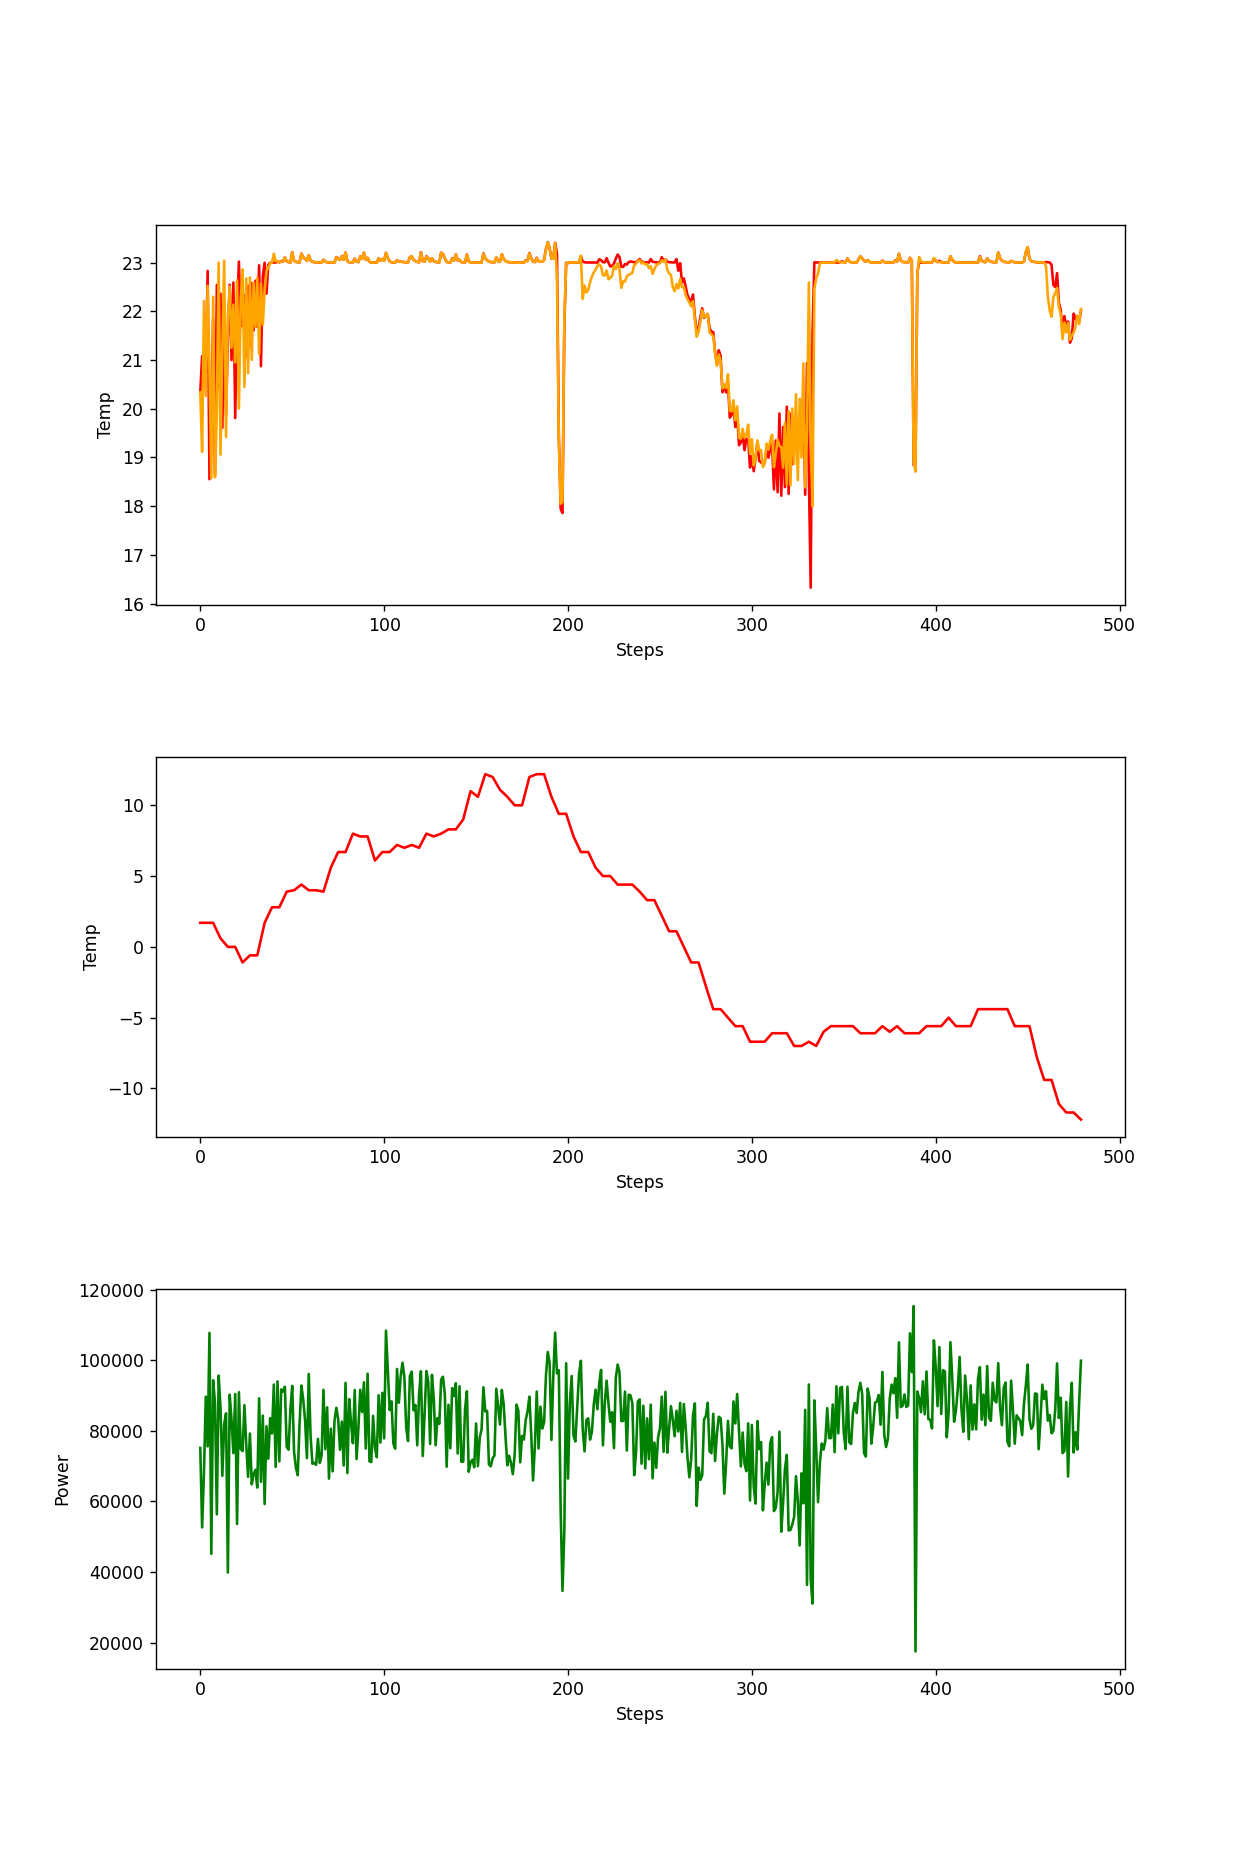

In [8]:
import matplotlib.pyplot as plt
%matplotlib notebook

f, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,15))


ax1.plot(out_df['Z01_T'], 'r')
ax1.plot(out_df['Z02_T'], 'orange')
ax1.set_ylabel('Temp')
ax1.set_xlabel('Steps')

ax2.plot(out_df['Ext_T'], 'r')
ax2.set_ylabel('Temp')
ax2.set_xlabel('Steps')

ax3.plot(out_df['Fa_Pw_All'], 'g')
ax3.set_ylabel('Power')
ax3.set_xlabel('Steps')

plt.subplots_adjust(hspace=0.4)

plt.show()

In [ ]:
env.close()